This notebook focuses on data visualization for:
- descriptive analysis 
- context bucket prevalence and co-occurrence
- temporal trends (volume + bucket composition)
- engagement metrics (likes/reposts/replies)
- sentiment (VADER)
- topic model summaries (NMF)

In [ ]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid')

CWD = Path().resolve()

def find_project_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / 'src' / 'run_analysis.py').exists() and (candidate / 'data').exists():
            return candidate
    return start

PROJECT_ROOT = find_project_root(CWD)
print('PROJECT_ROOT:', PROJECT_ROOT)

SRC_PATH = PROJECT_ROOT / 'src'
if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

import run_analysis  # noqa: E402

PROCESSED_PATH = PROJECT_ROOT / 'data' / 'processed' / 'cleaned_posts.csv'
if not PROCESSED_PATH.exists():
    raise FileNotFoundError(f'Expected cleaned CSV at {PROCESSED_PATH}. Run: python3 src/clean_data.py')
PROCESSED_PATH


PROJECT_ROOT: /Users/yuqingxing/Downloads/project


PosixPath('/Users/yuqingxing/Downloads/project/data/processed/cleaned_posts.csv')

In [2]:
# Load data
df = pd.read_csv(PROCESSED_PATH)
buckets = run_analysis.CONTEXT_BUCKETS
eng_cols = ["like_count", "repost_count", "reply_count"]

df.shape

(70138, 22)

## 1) Dataset overview

In [3]:
overview = {
    "rows": len(df),
    "unique_authors": df["author_handle"].nunique(dropna=True),
    "date_min": pd.to_datetime(df["created_at"], errors="coerce", utc=True).min(),
    "date_max": pd.to_datetime(df["created_at"], errors="coerce", utc=True).max(),
}
overview

{'rows': 70138,
 'unique_authors': 38478,
 'date_min': Timestamp('2024-01-01 20:39:43.198000+0000', tz='UTC'),
 'date_max': Timestamp('2025-12-13 23:59:28.010000+0000', tz='UTC')}

## 2) Context buckets

In [4]:
# Prevalence table
rows = []
for b in buckets:
    if b not in df.columns:
        continue
    rows.append({
        "bucket": b,
        "count": int(df[b].fillna(False).sum()),
        "pct": float(df[b].fillna(False).mean() * 100),
    })
bucket_df = pd.DataFrame(rows).sort_values("pct", ascending=False).reset_index(drop=True)
bucket_df

,bucket,count,pct
0,curriculum,9628,13.727223
1,assessment,7958,11.346203
2,stakeholders,2949,4.204568
3,professional_dev,2543,3.625709
4,policy,2369,3.377627
5,edtech_tools,1915,2.730332
6,infrastructure,908,1.294591
7,support_services,724,1.032251


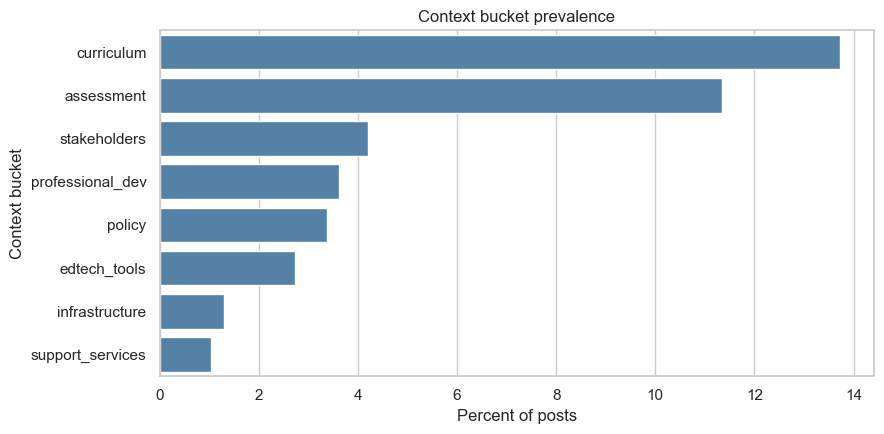

In [5]:
# Prevalence bar chart
plt.figure(figsize=(9, 4.5))
sns.barplot(data=bucket_df, x="pct", y="bucket", color="steelblue")
plt.xlabel("Percent of posts")
plt.ylabel("Context bucket")
plt.title("Context bucket prevalence")
plt.tight_layout()
plt.show()

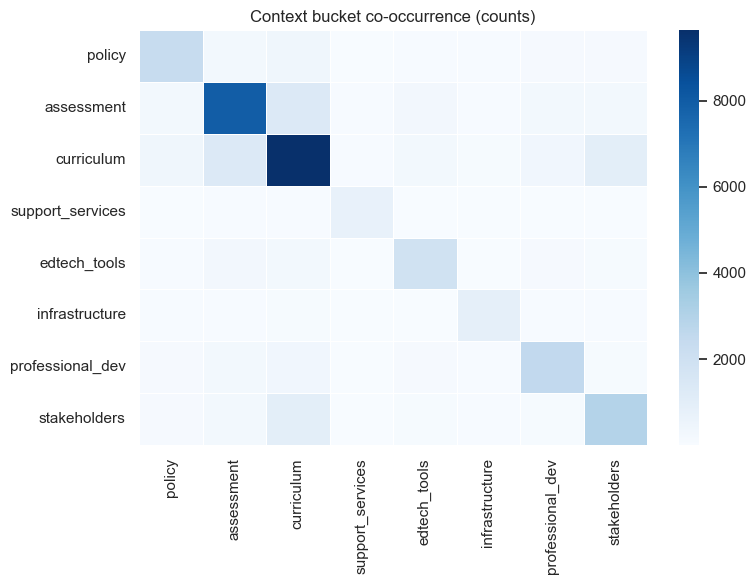

In [6]:
# Bucket co-occurrence heatmap (counts)
bucket_matrix = df[buckets].fillna(False).astype(int)
co_counts = bucket_matrix.T.dot(bucket_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(co_counts, cmap="Blues", linewidths=0.5)
plt.title("Context bucket co-occurrence (counts)")
plt.tight_layout()
plt.show()

## 3) Temporal trends

In [7]:
# Parse timestamps (UTC) and build daily aggregates
df = df.copy()
df["created_at_dt"] = pd.to_datetime(df["created_at"], errors="coerce", utc=True)
ts = df.dropna(subset=["created_at_dt"]).copy()
ts["date"] = ts["created_at_dt"].dt.date

daily_counts = ts.groupby("date").size().rename("count").reset_index()
daily_counts.head()

,date,count
0,2024-01-01,2
1,2024-01-02,8
2,2024-01-03,10
3,2024-01-04,5
4,2024-01-05,6


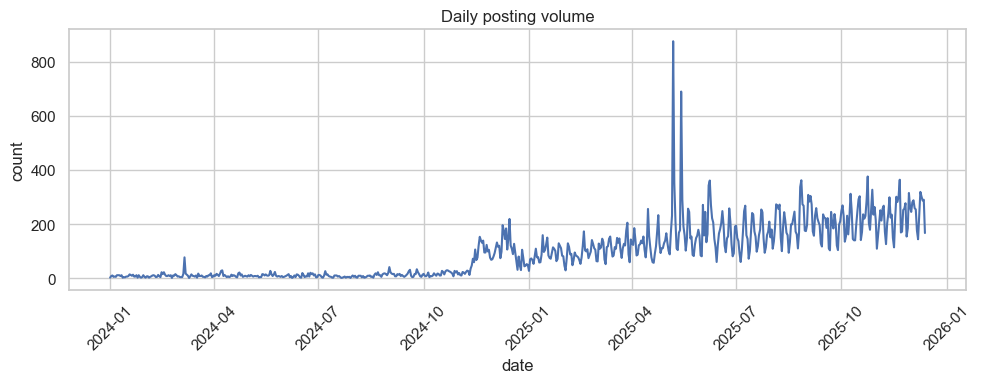

In [8]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=daily_counts, x="date", y="count")
plt.xticks(rotation=45)
plt.title("Daily posting volume")
plt.tight_layout()
plt.show()

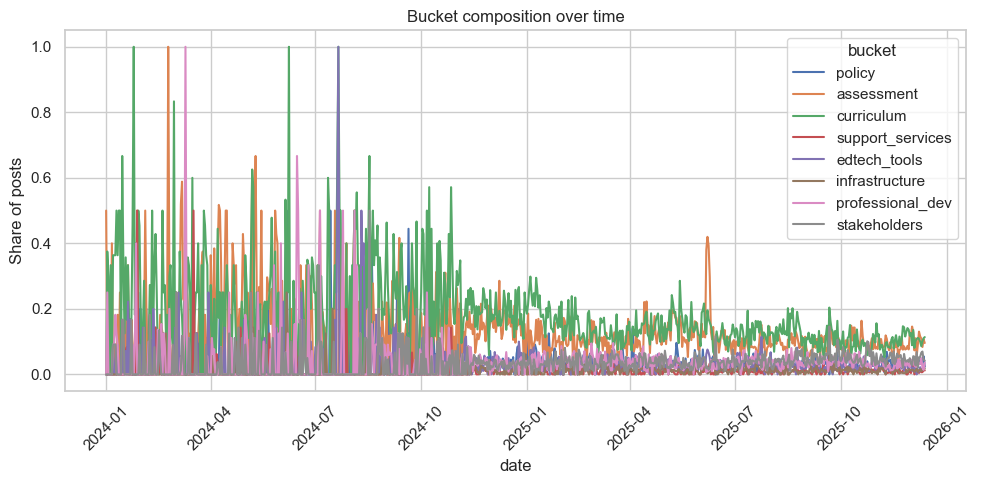

In [9]:
# Bucket composition over time (daily share)
daily_share = ts.groupby("date")[buckets].mean().reset_index()
daily_share_long = daily_share.melt(id_vars="date", var_name="bucket", value_name="share")

plt.figure(figsize=(10, 5))
sns.lineplot(data=daily_share_long, x="date", y="share", hue="bucket")
plt.xticks(rotation=45)
plt.ylabel("Share of posts")
plt.title("Bucket composition over time")
plt.tight_layout()
plt.show()

## 4) Engagement metrics

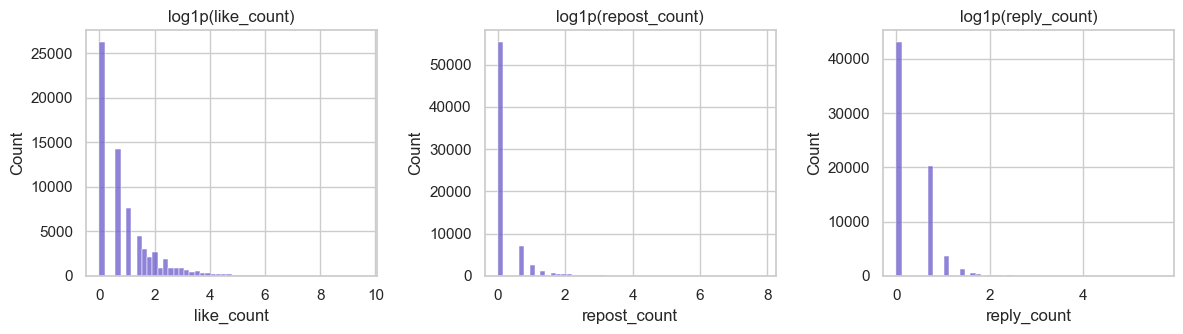

In [10]:
# Overall engagement distributions (log1p)
df_eng = df[eng_cols].fillna(0).clip(lower=0)
df_log = np.log1p(df_eng)

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
for ax, col in zip(axes, eng_cols):
    sns.histplot(df_log[col], bins=50, ax=ax, color="slateblue")
    ax.set_title(f"log1p({col})")
plt.tight_layout()
plt.show()

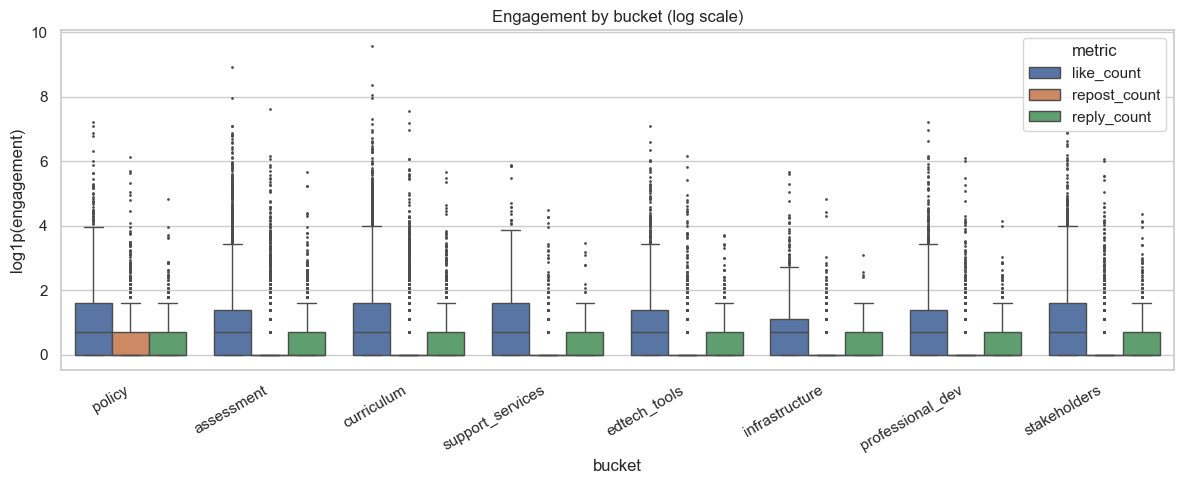

In [11]:
# Engagement by bucket: boxplots (log1p)
long_rows = []
for b in buckets:
    if b not in df.columns:
        continue
    mask = df[b].fillna(False).astype(bool)
    if mask.sum() == 0:
        continue
    subset = df.loc[mask, eng_cols].fillna(0).clip(lower=0)
    for col in eng_cols:
        long_rows.append(pd.DataFrame({
            "bucket": b,
            "metric": col,
            "value": np.log1p(subset[col].values),
        }))
eng_long = pd.concat(long_rows, ignore_index=True) if long_rows else pd.DataFrame(columns=["bucket","metric","value"])

plt.figure(figsize=(12, 5))
sns.boxplot(data=eng_long, x="bucket", y="value", hue="metric", fliersize=1)
plt.xticks(rotation=30, ha="right")
plt.ylabel("log1p(engagement)")
plt.title("Engagement by bucket (log scale)")
plt.tight_layout()
plt.show()

## 5) Sentiment (VADER)

In [12]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon', quiet=True)

sia = SentimentIntensityAnalyzer()
df = df.copy()
df["sentiment"] = df["text_clean"].fillna("").apply(lambda x: sia.polarity_scores(x)["compound"])
df["sentiment"].describe(percentiles=[0.1, 0.5, 0.9])

count    70138.000000
mean         0.145228
std          0.507873
min         -0.988800
10%         -0.617400
50%          0.153100
90%          0.795900
max          0.988000
Name: sentiment, dtype: float64

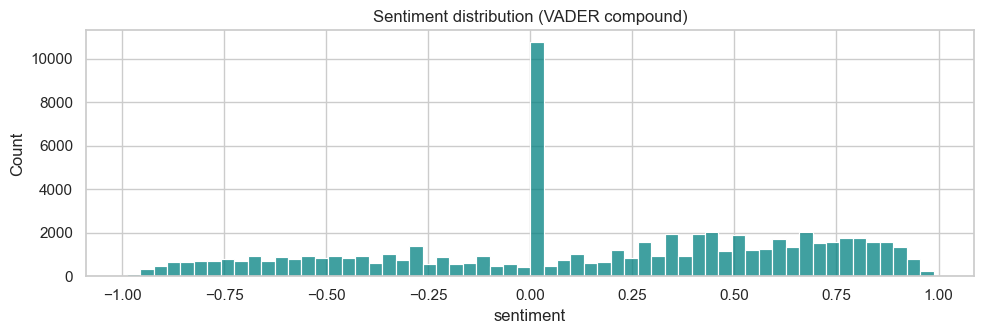

In [13]:
plt.figure(figsize=(10, 3.5))
sns.histplot(df["sentiment"], bins=60, color="teal")
plt.title("Sentiment distribution (VADER compound)")
plt.tight_layout()
plt.show()

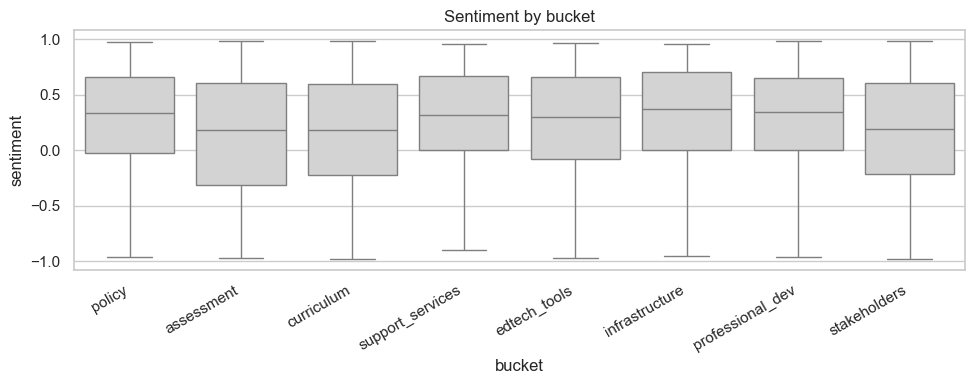

In [14]:
# Sentiment by bucket
sent_rows = []
for b in buckets:
    if b not in df.columns:
        continue
    mask = df[b].fillna(False).astype(bool)
    if mask.sum() == 0:
        continue
    sent_rows.append(pd.DataFrame({"bucket": b, "sentiment": df.loc[mask, "sentiment"].values}))
sent_long = pd.concat(sent_rows, ignore_index=True) if sent_rows else pd.DataFrame(columns=["bucket","sentiment"])

plt.figure(figsize=(10, 4))
sns.boxplot(data=sent_long, x="bucket", y="sentiment", color="lightgray", fliersize=1)
plt.xticks(rotation=30, ha="right")
plt.title("Sentiment by bucket")
plt.tight_layout()
plt.show()

## 6) Top terms / phrases (tf-idf)

In [15]:
vectorizer = run_analysis.get_vectorizer(max_features=50000)
tfidf = vectorizer.fit_transform(df["text_clean"].fillna(""))
feature_names = vectorizer.get_feature_names_out()

overall_top = run_analysis.top_terms(tfidf, feature_names, top_n=30)
overall_top_df = pd.DataFrame(overall_top, columns=["term", "score"])
overall_top_df

,term,score
0,ai,2565.035188
1,school,1229.648467
2,student,1098.570735
3,chatgpt,1041.824370
4,use,953.854565
5,students,883.500891
6,teacher,839.049242
7,just,768.576044
8,like,750.692079
9,professor,731.741924


## 7) Topic modeling summary (NMF)

This is an exploratory view; tune `n_topics` and inspect top documents for interpretability.

In [16]:
from sklearn.decomposition import NMF

n_topics = 15
vectorizer_topics = run_analysis.get_vectorizer(max_features=50000)
tfidf_topics = vectorizer_topics.fit_transform(df["text_clean"].fillna(""))
terms = np.array(vectorizer_topics.get_feature_names_out())

nmf = NMF(n_components=n_topics, random_state=42, init="nndsvda", max_iter=300)
W = nmf.fit_transform(tfidf_topics)
H = nmf.components_

topic_terms = []
for t in range(n_topics):
    top_idx = np.argsort(H[t])[::-1][:12]
    topic_terms.append({"topic": t, "terms": ", ".join(terms[top_idx])})
topics_df = pd.DataFrame(topic_terms)
topics_df

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


,topic,terms
0,0,"like, just, don, think, know, people, assignme..."
1,1,"tools, ai tools, tools just, cutt, unlimited a..."
2,2,"chatgpt, use chatgpt, using chatgpt, write, ch..."
3,3,"school, high, high school, old, ai, kids, old ..."
4,4,"use, use ai, ai use, ai, assignment, use chatg..."
5,5,"com, www, 2025, news, com 2025, com news, yout..."
6,6,"using, using ai, using chatgpt, students using..."
7,7,"admin, trump, trump admin, ai, tech, biden, mu..."
8,8,"score, aiイラスト, aiart, aiart aiイラスト, uniform, s..."
9,9,"student, llm, writing, ai, generated, work, pa..."


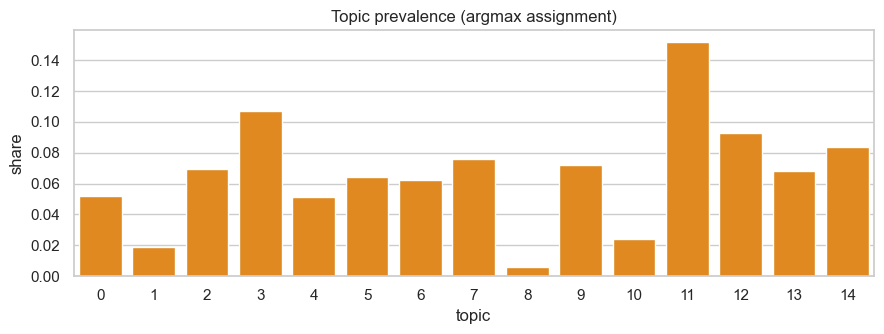

,topic,share
0,0,0.052140
1,1,0.018834
2,2,0.069563
3,3,0.107189
4,4,0.051085
5,5,0.064487
6,6,0.062491
7,7,0.076235
8,8,0.005717
9,9,0.072158


In [17]:
# Topic prevalence across documents
topic_share = pd.Series(W.argmax(axis=1)).value_counts(normalize=True).sort_index().rename_axis("topic").reset_index(name="share")

plt.figure(figsize=(9, 3.5))
sns.barplot(data=topic_share, x="topic", y="share", color="darkorange")
plt.title("Topic prevalence (argmax assignment)")
plt.tight_layout()
plt.show()

topic_share

In [18]:
# Inspect exemplar posts for a chosen topic
topic_id = 0
top_doc_idx = np.argsort(W[:, topic_id])[::-1][:8]
df.loc[top_doc_idx, ["created_at", "author_handle", "text"]]

,created_at,author_handle,text
10127,2024-10-22T07:21:30.509Z,riffenchan13.bsky.social,Ngl I have to make a website for a college ass...
7309,2025-11-02T02:53:37.905Z,autisticstarfruit.bsky.social,I composed a piece for class - my family is co...
69410,2025-05-26T23:03:24.070Z,thomasfuchs.at,"Fwiw I don’t have a concern with LLM as such, ..."
9845,2024-12-06T13:11:55.994Z,taralorraine.bsky.social,This was an in-class handwriting assignment 😭 ...
39024,2025-09-08T03:07:20.056Z,truewolfbird.bsky.social,"I hate ai, but also just don't care for abstra..."
33689,2025-11-25T09:37:08.867Z,bubbietea.bsky.social,"it's just sad because i was like ""i don't thin..."
48613,2025-11-03T22:33:29.521Z,lastnpcalex.agency,"i don't think they're wholly wrong, but it is ..."
44329,2025-08-14T17:11:00.628Z,gilmanhernandez.bsky.social,It plays with my sympathies—it sounds like an ...
